<a href="https://colab.research.google.com/github/arakoma/pytorch_practice/blob/master/writing_custum_datasets_dataloaders_and_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataのロード,preprocess,augmentについてやっていく！

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 画像の読み込みとかはopencvでやる(tutorialはio)
import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

google drive のマウント

In [37]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
%cd /content/drive/My Drive
!mkdir data
# data フォルダに、ダウンロードしたfacesデータ入れとく
# （/content/drive/My Drive/data/faces にする）

/content/drive/My Drive
mkdir: cannot create directory ‘data’: File exists


csvファイルにまとまってるので見てみる

In [39]:
landmarks_frame = pd.read_csv("data/faces/face_landmarks.csv")

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype("float").reshape(-1, 2)

print(img_name)
print(landmarks.shape)
print("first 5 landmarks :", landmarks[:5])

person-7.jpg
(68, 2)
first 5 landmarks : [[ 32.  65.]
 [ 33.  76.]
 [ 34.  86.]
 [ 34.  97.]
 [ 37. 107.]]


画像にlandmarkのせて見てみる

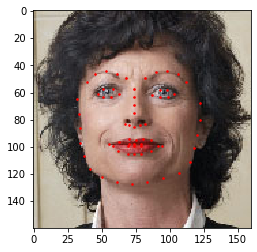

In [46]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)
    

image = cv2.imread("data/faces/{}".format(img_name))
image = image[:, :, (2, 1, 0)]

plt.figure()
show_landmarks(image, landmarks)
plt.show()

datasetをclassで扱っていく  
dataset class つくる  

torch.utils.data.Dataset classを継承して、__len__, __getitem__メソッドを上書きする

In [0]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = image[:, :, (2, 1, 0)]

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype("float").reshape(-1, 2)

        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

最初の4枚だけ見てみる

0 image: (324, 215, 3) landmark: (68, 2)


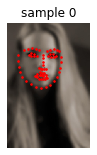

1 image: (500, 333, 3) landmark: (68, 2)


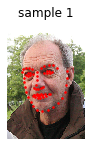

2 image: (250, 258, 3) landmark: (68, 2)


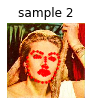

3 image: (434, 290, 3) landmark: (68, 2)


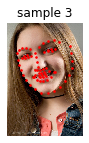

In [55]:
face_dataset = FaceLandmarksDataset(csv_file="data/faces/face_landmarks.csv",
                                    root_dir="data/faces/")

plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset.__getitem__(i)

    print(i, "image:", sample["image"].shape, "landmark:", sample["landmarks"].shape)

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title("sample {}".format(i))
    ax.axis("off")
    show_landmarks(sample["image"], sample["landmarks"])

    if i == 3:
        plt.show()
        break

画像変換(transform)をclassで書く  
- rescale
- random crop
- to tensor (numpy -> tensor)  
を実装してみる

In [0]:
# 続きここから